# Edition Multi-Pivots : Vers une Edition Multi-Directionnelle et Démêlée

Les réseaux antagonistes génératifs (GAN) permettent d’éditer des images en manipulant leurs caractéristiques. Cependant, ces manipulations ne sont pas toujours démêlées. Par exemple, lorsqu’une ride spécifique est modifiée, d’autres caractéristiques liées à l’âge sont souvent modifiées également. Cet article propose une nouvelle méthode d’édition démêlée. L’approche présentée est basée sur des images pivots qui permettent d’apprendre des directions d’édition pour une image d’entrée. Ces pivots sont basés sur une image réelle (l’entrée) et des modifications synthétiques de l’image réelle. Bien que notre principal cas d’applications d’édition soit les rides, notre méthode peut être étendue à d’autres tâches d’édition, telles que l’édition de la couleur des cheveux ou du rouge à lèvres. Les résultats qualitatifs et quantitatifs montrent que notre Edition Multi-Pivots (EMP) fournit un niveau plus élevé de démêlage et une édition plus réaliste que les méthodes de l’état de l’art.

# Set up

If you are on Windows please install C++ with Microsoft Visual Studio to be able to run StyleGAN plugins. Once install you may need to change the path of the VsDevCmd.bat

In [1]:
# Reload all modules
%load_ext autoreload
%autoreload 2

# Set up msvc to load the generator
import os
import platform

if platform.system() == "Windows":
    assert os.path.exists(r"C:\Program Files\Microsoft Visual Studio\2022\Community\Common7\Tools\VsDevCmd.bat"), "The path to VsDevCmd is not valid, please modify it"
    # Warning: The path may not be exact for you, please check it!
    os.system(r'"C:\Program Files\Microsoft Visual Studio\2022\Community\Common7\Tools\VsDevCmd.bat" -arch=x64 -host_arch=x64')
    
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import warnings
warnings.filterwarnings("ignore")

In [2]:
import json
import torch
import numpy as np
import cv2

from generator.utils import gen_w_space, keep_w, keep_w_image, load_stylegan2_generator, stylegan_invert_img_convert
from invertor.pte import PivotalTuningEdition
from image.edit import transfer_color, wrinkle_remover

In [3]:
# Config file of the generator
config_path = "./generator/stylegan2/config_1024.json"

with open(config_path, "r+") as config:
    generator = load_stylegan2_generator(json.load(config))

# Custom argument of the generator
generator_kwargs = {
    "input_is_latent": True,
    "return_latents": False,
    "input_is_style": False,
    "noise_mode": "const",
}

Loading StyleGAN2 from checkpoint: C:\Users\Neil\OneDrive - Professional\Documents\Python scripts\These\TheseUtils\generator\pretrained_models\stylegan2\stylegan2_1024.pt


In [4]:
space_modifier = lambda x: x.repeat(1, 18, 1)
space_kept = keep_w
space_kept_image = keep_w_image

initial_latent_modifier = lambda x : x[..., 0, :].reshape(1, 1, -1).to("cuda").requires_grad_(True)
input_generator = [
    lambda: gen_w_space(
        generator, z_dim=512
    ).unsqueeze(0),
    lambda: torch.zeros([1, 0], device="cuda"),
]
latent_from_flat = lambda latent: latent[np.newaxis, np.newaxis, ...]
loaded_latents = torch.stack([
    input_generator[0]() for x in range(1000)
]).squeeze(1)
initial_latent = initial_latent_modifier(loaded_latents.mean(axis=0))

Setting up PyTorch plugin "bias_act_plugin"... Done.


# Generating image with StyleGAN

Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


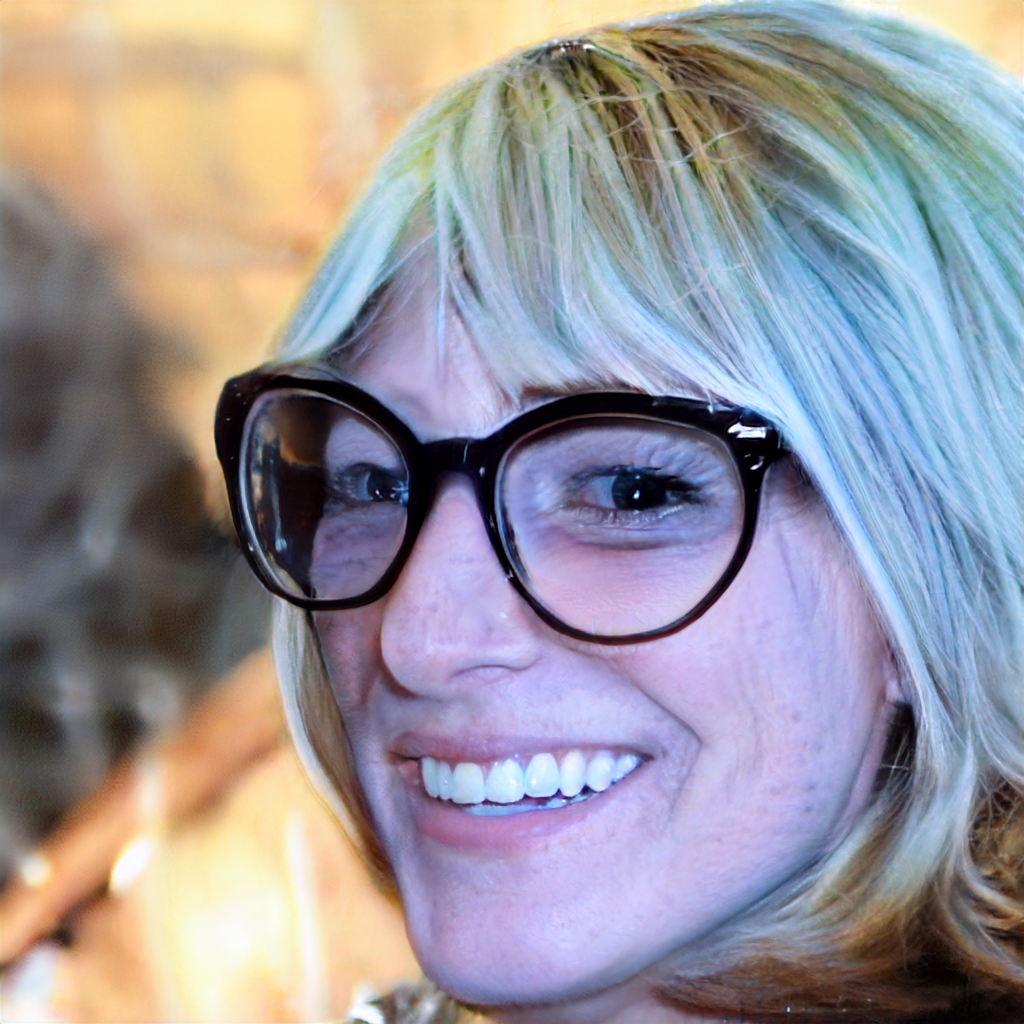

In [5]:
w = input_generator[0]()
c = input_generator[1]()

stylegan_invert_img_convert(
    generator(w, c, **generator_kwargs)
)

## Create PGT

The PGT (or Pseudo Ground Truth) is the real image to edit modified using tradionnal computer vision methods (such as histogram matching or poison blending).

In [6]:
img_path = "./Exemples/164462.jpg"
target_path = "./Exemples/00991.png"

# Creates the PGT for lips
pgt_lips = transfer_color(img_path, target_path, "Lips")
cv2.imwrite(r"./Exemples/pgt_lips.png", pgt_lips)

# Creates the PGT for hair
pgt_hair = transfer_color(img_path, target_path, "Hair")
cv2.imwrite(r"./Exemples/pgt_hair.png", pgt_hair)

# Creates the PGT for lion wrinkle
pgt_wrinkle = wrinkle_remover(img_path, "LionWrinkle")
cv2.imwrite(r"./Exemples/pgt_wrinkle.png", pgt_wrinkle)

True

## Run the PTE algorithm

The PTE run in 3 steps + 1 optional

In [7]:
emp_dir = PivotalTuningEdition(
    generator=generator, target=img_path, 
    generator_kwargs=generator_kwargs, space_modifier=space_modifier
)

emp_dir.synthethise_with_multi_directions(
    pseudo_target=[
        r"./Exemples/pgt_lips.png",
        r"./Exemples/pgt_hair.png",
        r"./Exemples/pgt_wrinkle.png",
    ],
    direction=None, invertion_iteration=1000, tuning_iteration=750,
    initial_latent_function=initial_latent, gradient_optimizer=torch.optim.Adam,
    tune_optimizer=torch.optim.Adam, direction_type="Double_Invertion"
)

100%|██████████| 750/750 [06:05<00:00,  2.05it/s]


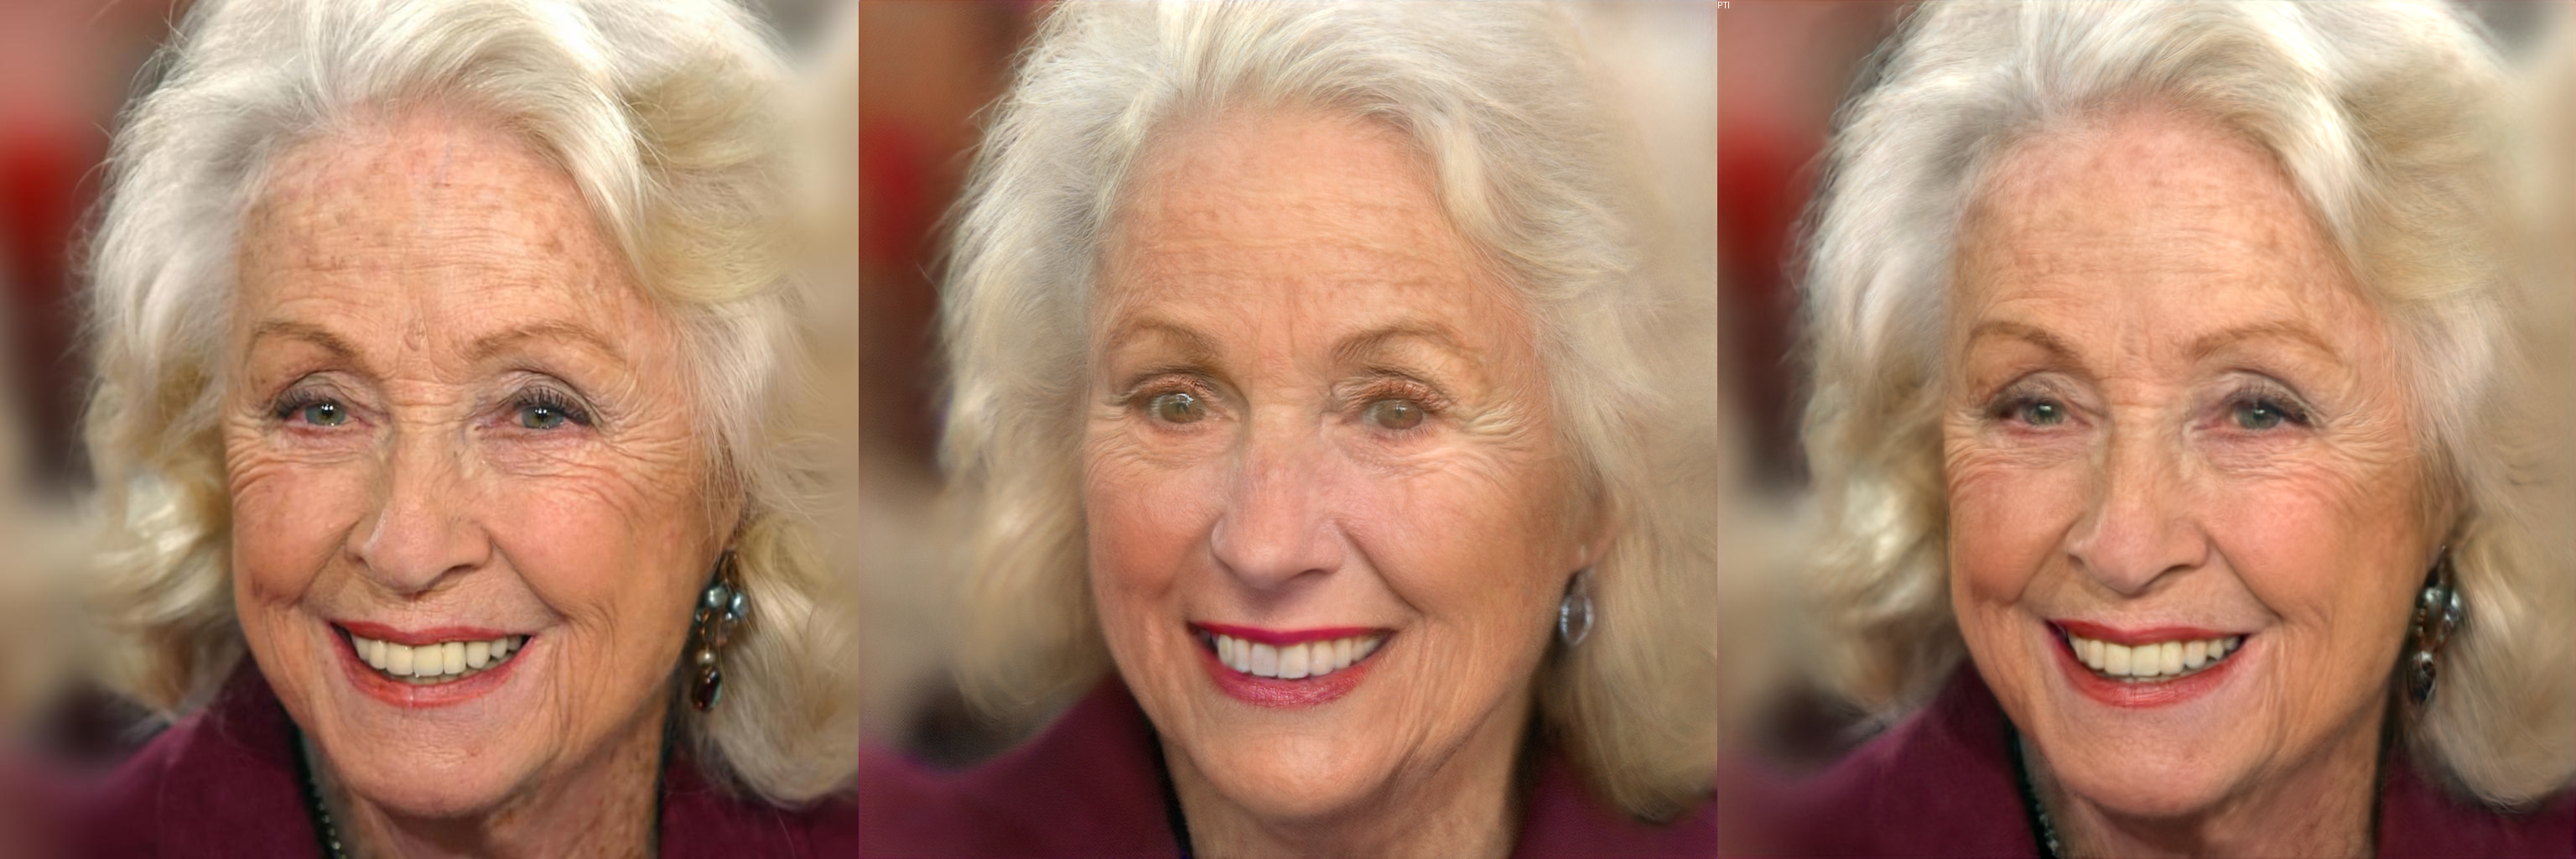

In [8]:
emp_dir.show_result()

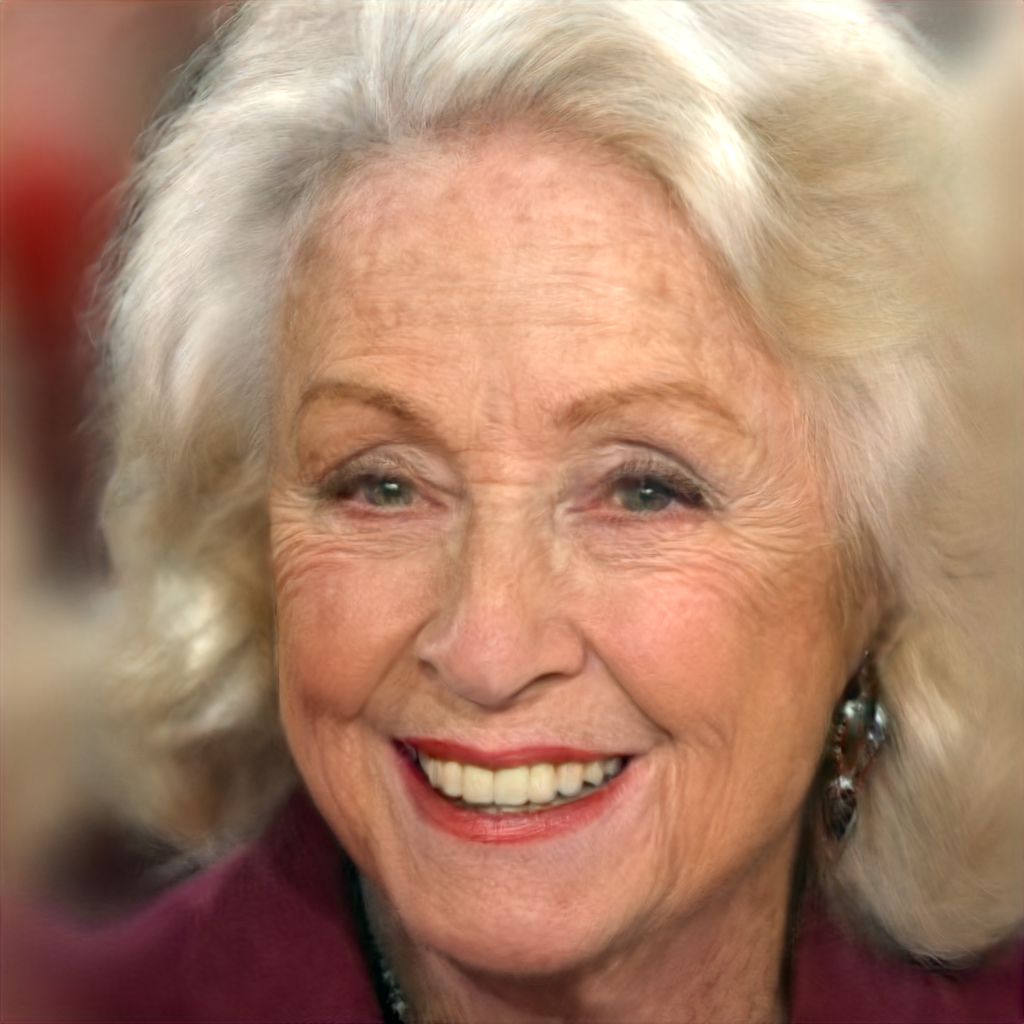

In [9]:
# You can modify the value of alpha to edit
emp_dir.edit_pivot(alpha=torch.Tensor([1, 0, 0.2]).cuda())

In [10]:
# Save the trained model to be able to edit with an interface (check app.py for this)
emp_dir.save("./pte.pkl")